In [1]:
from scipy.interpolate import interp1d
from glob import glob
from spec_id import Gen_spec, Median_model, Scale_model, Oldest_galaxy, \
    Stack_posteriors, Median_w_Error_cont, Linear_fit
from vtl.Readfile import Readfile
import seaborn as sea
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
colors = [(0,i,i,i) for i in np.linspace(0,1,3)]
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.2, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

1) $F_i(\lambda)=F_o(\lambda)10^{0.4E_s (B-V)k'(\lambda)}$

2) $E_s(B-V)=(0.44 \pm 0.03)E(B-V)$

3) $k'(\lambda)=2.659(-2.156 +1.509/\lambda -0.198/\lambda^2 +0.011/\lambda^3) + R'_v$

4) $R'(\lambda)=4.05 \pm 0.8$

5) $A(V)=R(V)E(B-V)$

In [72]:
def Calzetti(Av,lam,flux,data_fl,data_er):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)
    C = Scale_model(data_fl,data_er,(flux * cal))
    
    print C
    
    return (flux * cal * C)

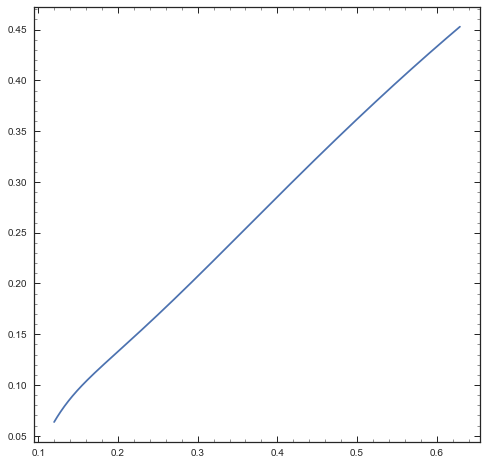

In [32]:
%matplotlib inline

plt.figure(figsize=[8,8])
plt.plot(lam,cal)


In [38]:
spec = Gen_spec(galDB['gids'][61], galDB['hi_res_specz'][61],delayed=True,maxwv=11400)
bftau = Median_model(galDB['gids'][61], galDB['hi_res_specz'][61], galDB['Z_lwa'][61], galDB['t_lwa'][61], tau)
spec.Sim_spec(galDB['Z_lwa'][61],galDB['t_lwa'][61],bftau)

../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat
../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../dat

/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


1.5494340497


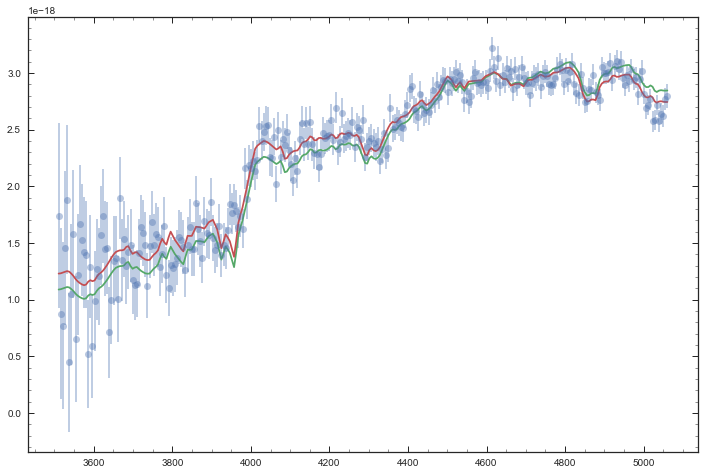

In [76]:
dfl = Calzetti(.4,spec.gal_wv_rf,spec.fl,spec.gal_fl, spec.gal_er)

plt.figure(figsize=[12,8])
plt.errorbar(spec.gal_wv_rf,spec.gal_fl,spec.gal_er,fmt='o',alpha=.4)
plt.plot(spec.gal_wv_rf, dfl)
plt.plot(spec.gal_wv_rf, spec.fl)

# Dust plots

In [3]:
def Gen_grid(DB,param):
    grid=[]
    for i in DB.index:
        x,Px = np.load('../chidat/%s_dtau_%s_pos_lwa_dust.npy' % (DB['gids'][i],param))
        grid.append(Px)
    return np.array(grid)

In [4]:
"""DATA"""
rzoo = importr('zoo')

age_range = np.arange(0,3,0.05)

gmtlDB = galDB.query('ids != 14713 and ids != 38126 and ids != 40597')

Pl_grid = Gen_grid(lzDB,'t')
Pm_grid = Gen_grid(mzDB,'t')
Ph_grid = Gen_grid(hzDB,'t')
Puh_grid = Gen_grid(uhzDB,'t')

Pl = Stack_posteriors(Pl_grid,age)
Pm = Stack_posteriors(Pm_grid,age)
Ph = Stack_posteriors(Ph_grid,age)
Puh = Stack_posteriors(Puh_grid,age)

lmed,ller,lher=Median_w_Error_cont(Pl,age)
mmed,mler,mher=Median_w_Error_cont(Pm,age)
hmed,hler,hher=Median_w_Error_cont(Ph,age)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,age)

lt=np.array(lzDB['tx_cal'])
mt=np.array(mzDB['tx_cal'])
ht=np.array(hzDB['tx_cal'])
uht=np.array(uhzDB['tx_cal'])
gmtlt=np.array(gmtlDB['tx_cal'])

fumx,fumy=Readfile('../data/fumagalli_fig14.dat',0)
d,fverr=Readfile('../data/fumagalli_fig14_verr.dat',0)
fherr,d=Readfile('../data/fumagalli_fig14_herr.dat',0)

verr=np.zeros(len(fverr))
herr=np.zeros(len(fherr))
for i in range(len(verr)):
    verr[i]=np.abs(fverr[i]-fumy[i])
    herr[i]=np.abs(fherr[i]-fumx[i])
    
gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
                                                                            skiprows=31,delimiter=',').T
mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
                        'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
                       'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
IDW =z_g.argsort()
eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in rbind.zoo(...) : indexes overlap

  warnings.warn(x, RRuntimeWarning)
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: There were 11 warnings (use warnings() to see them)
  warnings.warn(x, RRuntimeWarning)
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: in

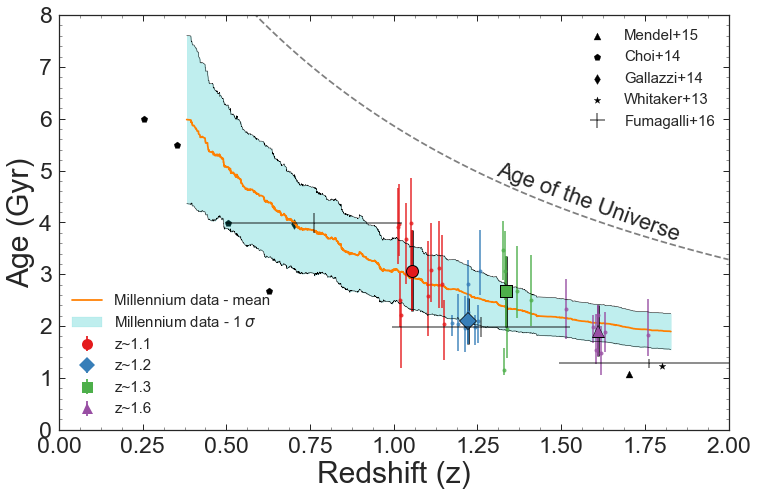

In [5]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

ax1=plt.scatter(fumx[9],fumy[9],color = 'k',marker='^')         #,label='Mendel+15')
ax2=plt.scatter(fumx[10:14],fumy[10:14],color = 'k',marker='p') #,label='Choi+14')
ax3=plt.scatter(fumx[14],fumy[14],color = 'k',marker='d')       #,label='Gallazzi+14')
ax4=plt.scatter(fumx[15],fumy[15],color = 'k',marker='*')       #,label='Whitaker+13')
ax5=plt.errorbar(fumx[6:9],fumy[6:9],xerr=herr[6:9],yerr=verr[6:9]
             ,color='k',zorder=3,fmt='o',alpha=.5,ms=1)#,label='Fumagalli+16')

plt.errorbar(lzDB['hi_res_specz'],lt,yerr=[lzDB['tx_-_sig_cal'],lzDB['tx_+_sig_cal']],
             color='#e41a1c',alpha=.8,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],mt,yerr=[mzDB['tx_-_sig_cal'],mzDB['tx_+_sig_cal']],
             color='#377eb8',alpha=.8,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],ht,yerr=[hzDB['tx_-_sig_cal'],hzDB['tx_+_sig_cal']],
             color='#4daf4a',alpha=.8,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],uht,yerr=[uhzDB['tx_-_sig_cal'],uhzDB['tx_+_sig_cal']],
             color='#984ea3',alpha=.8,ms=4,fmt='o')

plt.errorbar(np.median(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color='k',elinewidth=2.5,ms=13,fmt='o')
plt.errorbar(np.median(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='k',elinewidth=2.5,ms=13,fmt='D')
plt.errorbar(np.median(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='k',elinewidth=2.5,ms=13,fmt='s')
plt.errorbar(np.median(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='k',elinewidth=2.5,ms=13,fmt='^')


plt.errorbar(np.median(lzDB['hi_res_specz']),lmed,yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']),mmed,yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']),hmed,yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']),uhmed,yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.plot(z_g[IDW],rmean,color = '#ff7f00',zorder=1,label = 'Millennium data - mean')
plt.plot(z_g[IDW],np.array(rstd) + np.array(rmean),'k',linewidth = .5)
plt.plot(z_g[IDW],np.array(rmean) - np.array(rstd),'k',linewidth = .5)
plt.fill_between(z_g[IDW],np.array(rmean) - np.array(rstd),np.array(rstd) + np.array(rmean),
                color='c',alpha = .25,label = 'Millennium data - 1 $\sigma$')
plt.axis([0.,2.0,0,8])
# plt.axis([0.9,1.8,0,7])
plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Age (Gyr)',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.text(1.3,4.9,'Age of the Universe',rotation=-20,fontsize=22)
plt.gcf().subplots_adjust(bottom=0.16)
l1= plt.legend([ax1,ax2,ax3,ax4,ax5],['Mendel+15','Choi+14','Gallazzi+14','Whitaker+13','Fumagalli+16'],
              fontsize=15)
plt.legend(loc = 3, fontsize=15)
currentAxis.add_artist(l1)
# plt.show()
plt.savefig('../plots/agevz_featgroup_dust_dust.png',bbox_inches = 'tight')
# plt.close()

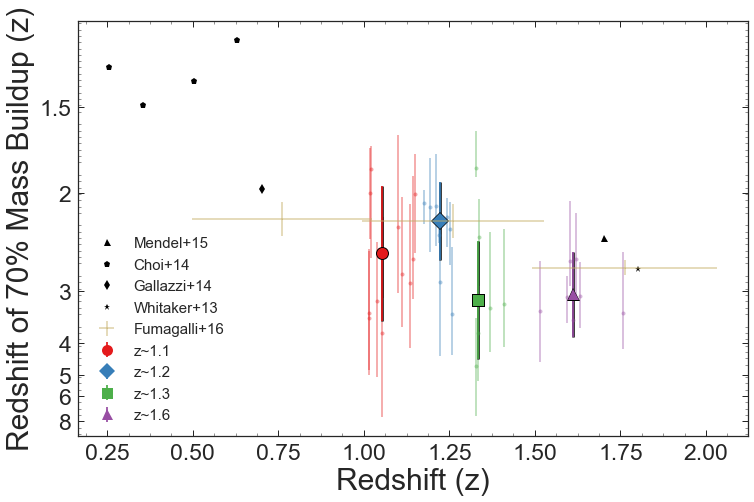

In [6]:
###PLOT
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
# plt.plot(z,ages,'k--',alpha=.5)

plt.errorbar(fumx[6:9],Oldest_galaxy(fumx[6:9]) - fumy[6:9],xerr=herr[6:9],yerr=verr[6:9]
             ,color=sea.color_palette('muted')[4],zorder=3,fmt='o',alpha=.5,ms=1,label='Fumagalli+16')
plt.plot(fumx[9], Oldest_galaxy(fumx[9]) - fumy[9],'k^',label='Mendel+15')
plt.plot(fumx[10:14],Oldest_galaxy(fumx[10:14]) - fumy[10:14],'kp',label='Choi+14')
plt.plot(fumx[14],Oldest_galaxy(fumx[14]) - fumy[14],'kd',label='Gallazzi+14')
plt.plot(fumx[15],Oldest_galaxy(fumx[15]) - fumy[15],'k*',label='Whitaker+13')

plt.errorbar(lzDB['hi_res_specz'], Oldest_galaxy(lzDB['hi_res_specz']) - lt,
             yerr=[lzDB['tx_-_sig_cal'],lzDB['tx_+_sig_cal']],color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['hi_res_specz'],Oldest_galaxy(mzDB['hi_res_specz']) - mt,
             yerr=[mzDB['tx_-_sig_cal'],mzDB['tx_+_sig_cal']],color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['hi_res_specz'],Oldest_galaxy(hzDB['hi_res_specz']) - ht,
             yerr=[hzDB['tx_-_sig_cal'],hzDB['tx_+_sig_cal']],color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.errorbar(uhzDB['hi_res_specz'],Oldest_galaxy(uhzDB['hi_res_specz']) - uht,
             yerr=[uhzDB['tx_-_sig_cal'],uhzDB['tx_+_sig_cal']],color='#984ea3',alpha=.4,ms=4,fmt='o')

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='k',ms=13,fmt='o',elinewidth=2.5)
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='k',ms=13,fmt='D',elinewidth=2.5)
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='k',ms=13,fmt='s',elinewidth=2.5)
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='k',ms=13,fmt='^',elinewidth=2.5)

plt.errorbar(np.median(lzDB['hi_res_specz']), Oldest_galaxy(np.median(lzDB['hi_res_specz'])) - lmed,
             yerr=[[ller,lher]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['hi_res_specz']), Oldest_galaxy(np.median(mzDB['hi_res_specz'])) - mmed,
             yerr=[[mler,mher]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['hi_res_specz']), Oldest_galaxy(np.median(hzDB['hi_res_specz'])) - hmed,
             yerr=[[hler,hher]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['hi_res_specz']), Oldest_galaxy(np.median(uhzDB['hi_res_specz'])) - uhmed,
             yerr=[[uhler,uhher]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.xlabel('Redshift (z)',size=30)
plt.ylabel('Redshift of 70% Mass Buildup (z)',size=30)
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278],[8,6,5,4,3,2,1.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
# plt.legend(fontsize=23)
plt.legend(loc=3,fontsize=15)
# plt.show()
plt.savefig('../plots/agevz_rshift_all_dust.png',bbox_inches = 'tight')
# plt.close()

In [7]:
"""DATA"""
gmtlDB = galDB.query('1.45 > hi_res_specz')
gmtlDB = gmtlDB.query('ids != 14713 and ids != 38126')

Pl_grid = Gen_grid(lzDB,'Z')
Pm_grid = Gen_grid(mzDB,'Z')
Ph_grid = Gen_grid(hzDB,'Z')
Puh_grid = Gen_grid(uhzDB,'Z')

Pl = Stack_posteriors(Pl_grid,metal)
Pm = Stack_posteriors(Pm_grid,metal)
Ph = Stack_posteriors(Ph_grid,metal)
Puh = Stack_posteriors(Puh_grid,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx_cal'])
mZ=np.array(mzDB['Zx_cal'])
hZ=np.array(hzDB['Zx_cal'])
uhZ=np.array(uhzDB['Zx_cal'])
gmtlZ=np.array(gmtlDB['Zx_cal'])

lerrs = gmtlDB['Zx_-_sig_cal']/(gmtlDB['Zx_cal'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_cal']/(gmtlDB['Zx_cal'] * np.log(10))
errs = (gmtlDB['Zx_-_sig_cal'] + gmtlDB['Zx_+_sig_cal']/2) / (gmtlDB['Zx_cal'] * np.log(10))
samp = np.arange(10,11.8,.01)
lfit,lfit_errs = Linear_fit(gmtlDB['lmass'],np.log10(gmtlZ/0.019),errs,samp)

# gID,z_g,z_a,redshift,ra,dec,smass,sfr,mWAge,rbWage,metalsSMass = np.loadtxt('../data/millennium2.txt',
#                                                                             skiprows=31,delimiter=',').T
# mill_DB = pd.DataFrame({'gID':gID,'z_geo':z_g,'z_all':z_a,
#                         'redshift':redshift,'ra':ra,'dec':dec,'stellar_mass':smass,'star_formation_rate':sfr,
#                        'mass_weighted_age':mWAge,'light_weighted_age':rbWage,'Z_stellar_mass':metalsSMass})
# IDW =z_g.argsort()
# eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
# rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
# rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

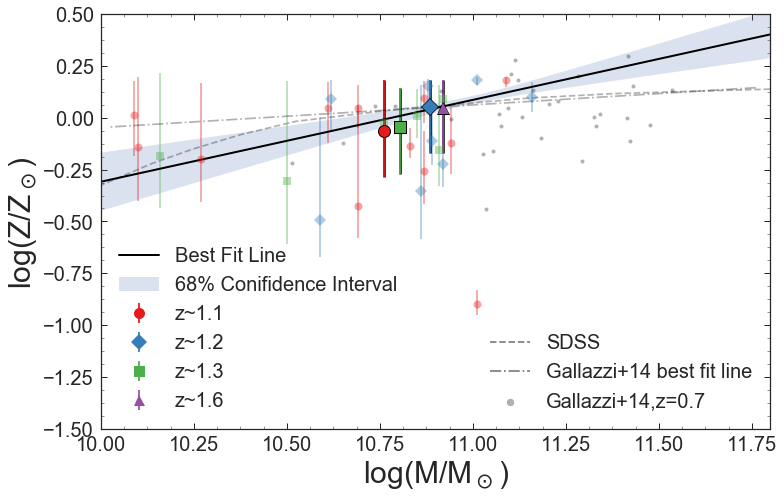

In [8]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.3,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.3)#,label='Gallazzi+14,z=0.7')
legend1 = plt.legend([sdss,galbf,galpts],['SDSS','Gallazzi+14 best fit line','Gallazzi+14,z=0.7'],loc = 4,fontsize=20)
currentAxis.add_artist(legend1)
#####single galaxy points
plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_-_sig_cal']/(lzDB['Zx_cal'] * np.log(10)),
                                                     lzDB['Zx_+_sig_cal']/(lzDB['Zx_cal'] * np.log(10))]
             ,color='#e41a1c',alpha=.4,ms=8,fmt='o')
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_-_sig_cal']/(mzDB['Zx_cal'] * np.log(10)),
                                                     mzDB['Zx_+_sig_cal']/(mzDB['Zx_cal'] * np.log(10))]
             ,color='#377eb8',alpha=.4,ms=8,fmt='D')
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_-_sig_cal']/(hzDB['Zx_cal'] * np.log(10)),
                                                     hzDB['Zx_+_sig_cal']/(hzDB['Zx_cal'] * np.log(10))]
             ,color='#4daf4a',alpha=.4,ms=8,fmt='s')
plt.plot(samp,lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,lfit - lfit_errs,lfit + lfit_errs,alpha = .2,label = '68% Conifidence Interval')

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],
            [lher/(lmed * np.log(10))]],color='k',ms=13,fmt='o',elinewidth=2.5)
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],
            [mher/(mmed * np.log(10))]], color='k',ms=13,fmt='D',elinewidth=2.5)
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],
            [hher/(hmed * np.log(10))]], color='k',ms=13,fmt='s',elinewidth=2.5)
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],
            [uhher/(uhmed * np.log(10))]], color='k',ms=13,fmt='^',elinewidth=2.5)

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],
            [lher/(lmed * np.log(10))]], color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],
            [mher/(mmed * np.log(10))]], color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],
            [hher/(hmed * np.log(10))]], color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],
            [uhher/(uhmed * np.log(10))]], color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=20)
# plt.show()
plt.savefig('../plots/metalmass_featgroup_dust.png',bbox_inches = 'tight')
# plt.close()